In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.svm import SVC

# Example 1: Classes easily separable by one parameter

In this example the toy dataset was created. It contains 120 samples, each belonging to one of three classes. Each class contains 40 samples. The training data is 12-dimensional vectors. First 11 are just gaussian noise containing no information benefitting the classification process. However, the 12th column is the indicator, that allows perfect separation of the classes.

### Step 1: Create the dataset

In [5]:
X_not_important = np.random.randn(120,11)
X_important = np.concatenate([np.random.randn(40) + 10 * i for i in range(3)]).reshape(-1,1)
X = np.concatenate([X_not_important, X_important], axis=1)
Y = np.concatenate([np.ones(40) * i for i in range(3)])

### Step 2: Split the dataset to train and test

In [31]:
train_test_split_ratio = 0.7

indices = np.arange(Y.shape[0])
np.random.shuffle(indices)

stop = int(Y.shape[0] * train_test_split_ratio)

train_indices, test_indices = indices[:stop], indices[stop:]
Xtrain, Xtest, Ytrain, Ytest = X[train_indices], X[test_indices], Y[train_indices], Y[test_indices]

### Step 3: Train model and evaluate it

In [32]:
model = DecisionTreeClassifier()
model.fit(Xtrain, Ytrain)

train_pred = model.predict(Xtrain)
test_pred = model.predict(Xtest)

acc_train = (train_pred == Ytrain).mean()
acc_test = (test_pred == Ytest).mean()

print(f"Accuracy on train set: {acc_train}")
print(f"Accuracy on test set: {acc_test}")

Accuracy on train set: 1.0
Accuracy on test set: 1.0


The accuracy on test set is 100% (as intended. After all, the dataset was purposefully created, so the pattern was trivial). Now, it is necessary to determine, whether there is a mistake in a code or the dataset contains patterns enabling clear discrimination between classes.

It is time to determine the quality of patterns found in the dataset.

### Step 4: Determine feature importance

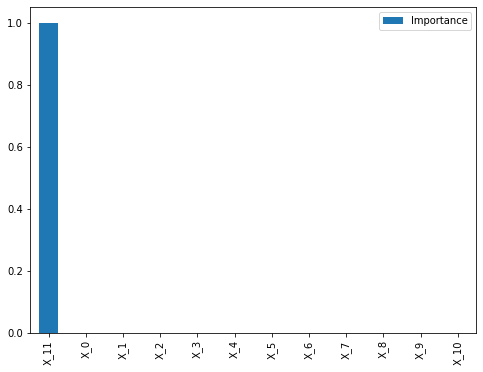

In [39]:
features_train = pd.DataFrame(data=Xtrain, columns=[f"X_{i}" for i in range(Xtrain.shape[1])])
feat_importances = pd.DataFrame(model.feature_importances_, index=features_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

plt.show()

The feature importance determined the last column ("X_11") as the most important. It is correct assumption, since columns from X_0 to X_10 are random noise and column X_11 was created in a way to contain information solely sufficient for discrimination between classes. As a result, it is known where to look next. 

### Step 5: Statistical analysis

Since model deemed only last column as important, we will evaluate only this one. The first thing to do I recommend is to visualize the data. We will do so with the scatter plot.

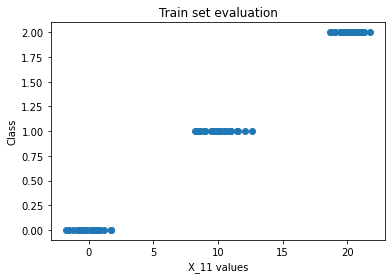

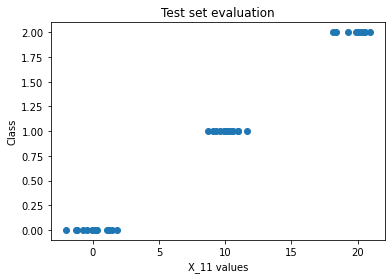

In [42]:
plt.scatter(Xtrain[:,11], Ytrain)
plt.title("Train set evaluation")
plt.xlabel("X_11 values")
plt.ylabel("Class")

plt.show()


plt.scatter(Xtest[:,11], Ytest)
plt.title("Test set evaluation")
plt.xlabel("X_11 values")
plt.ylabel("Class")

plt.show()

Plots depict the relationship between classes and values of X_11. It can be seen, that X_11 clearly determines the class of the sample through the division of its values. To finish our analysis we will perform ANOVA analysis to futher prove the statistical importance of separability.

In [47]:
df = pd.DataFrame(data=np.concatenate([X[:,11].reshape(-1,1), Y.reshape(-1,1)], axis=1), columns=["X_11", "Class"])
ols_model = ols("X_11 ~ C(Class)", data=df).fit()
anova_table = sm.stats.anova_lm(ols_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Class),7981.607156,2.0,4354.864166,1.444066e-110
Residual,107.218963,117.0,NaN,NaN


The last column of our test (PR(>F)) is orders of magnitude smaller than 0.05. As a result, the difference is significant. Because difference is significant, the model in fact could find such a pattern in our dataset, that allowed for achieving perfect 100% accuracy on test. It seems, that there is no error in the code, and the classification task in this particular example was in fact trivial.